In [1]:
import tensorflow as tf
import keras
import cv2
import numpy as np
import shutil

Using TensorFlow backend.


In [2]:
print(tf.__version__)
print(keras.__version__)

1.3.0
2.0.8


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

Load the simulator image index first.

In [4]:
import pandas as pd
import os

In [5]:
TRAIN_DATA_PATH = os.path.join('..', 'data', 'tl_recorder_images', 'train')
VALID_DATA_PATH = os.path.join('..', 'data', 'tl_recorder_images', 'valid')
TRAIN_CSV_PATH = os.path.join(TRAIN_DATA_PATH, 'index.csv')
VALID_CSV_PATH = os.path.join(VALID_DATA_PATH, 'index.csv')
assert os.path.exists(TRAIN_CSV_PATH), 'File doesn\'t exist: {0}'.format(TRAIN_CSV_PATH)
assert os.path.exists(VALID_CSV_PATH), 'File doesn\'t exist: {0}'.format(VALID_CSV_PATH)

class_map = ['unknown', 'red', 'yellow', 'green']
columns = [
        'file', 'light_visible', 'light_state', 'light_distance',
        'car_pos_x', 'car_pos_y', 'car_pos_z', 
        'car_rot_x', 'car_rot_y', 'car_rot_z', 'car_rot_w',
        'light_pos_x', 'light_pos_y', 'light_pos_z', 
        'light_rot_x', 'light_rot_y', 'light_rot_z', 'light_rot_w'
    ]

df_train_original = pd.read_csv(TRAIN_CSV_PATH, sep=',', names=columns)
df_train_original.sample(n=10)

,file,light_visible,light_state,light_distance,car_pos_x,car_pos_y,car_pos_z,car_rot_x,car_rot_y,car_rot_z,car_rot_w,light_pos_x,light_pos_y,light_pos_z,light_rot_x,light_rot_y,light_rot_z,light_rot_w
6899,1549220376_85.jpg,1,0,34.452157,2171.8420,1785.421,0.115782,0.0,0.0,0.679088,0.734057,2178.291,1819.328,5.576704,0.0,0.0,0.012154,0.999926
2721,1549219959_02.jpg,1,0,27.401253,1556.1220,1159.705,0.117678,-0.0,0.0,0.046768,-0.998906,1584.065,1156.953,5.576705,0.0,0.0,-0.000808,1.000000
6753,1549220362_23.jpg,1,2,42.840257,2170.5420,1777.148,0.112018,0.0,0.0,0.660683,0.750665,2178.291,1819.328,5.576704,0.0,0.0,0.012154,0.999926
6132,1549220300_09.jpg,0,0,259.700628,2130.8430,1564.107,0.096000,0.0,0.0,0.608417,0.793618,2178.291,1819.328,5.576704,0.0,0.0,0.012154,0.999926
3220,1549220008_94.jpg,1,2,29.610326,1554.3240,1162.619,0.117783,-0.0,0.0,0.044984,-0.998988,1584.065,1156.953,5.576705,0.0,0.0,-0.000808,1.000000
4479,1549220134_85.jpg,1,2,174.879784,2089.8220,1380.187,0.022571,0.0,0.0,0.606204,0.795309,2126.353,1550.636,5.576704,0.0,0.0,0.011119,0.999938
3222,1549220009_11.jpg,1,2,29.610326,1554.1490,1162.634,0.117827,-0.0,0.0,0.045070,-0.998984,1584.065,1156.953,5.576705,0.0,0.0,-0.000808,1.000000
2658,1549219952_71.jpg,1,0,33.585865,1550.2090,1160.260,0.117599,-0.0,0.0,0.047384,-0.998877,1584.065,1156.953,5.576705,0.0,0.0,-0.000808,1.000000
3241,1549220011_02.jpg,1,2,28.726697,1554.4430,1162.582,0.117726,-0.0,0.0,0.052136,-0.998640,1584.065,1156.953,5.576705,0.0,0.0,-0.000808,1.000000
1332,1549219781_12.jpg,1,2,43.319919,342.7813,1591.926,0.122306,-0.0,0.0,0.516508,-0.856282,363.378,1553.731,5.606708,0.0,0.0,-0.010369,0.999946


In [6]:
df_valid_original = pd.read_csv(VALID_CSV_PATH, sep=',', names=columns)
df_valid_original.sample(n=10)

,file,light_visible,light_state,light_distance,car_pos_x,car_pos_y,car_pos_z,car_rot_x,car_rot_y,car_rot_z,car_rot_w,light_pos_x,light_pos_y,light_pos_z,light_rot_x,light_rot_y,light_rot_z,light_rot_w
537,1549224008_15.jpg,1,2,55.672736,1527.243,1161.920,0.052793,-0.0,0.0,0.038963,-0.999241,1584.065,1156.953,5.576705,0.0,0.0,-0.000808,1.0
47,1549223959_19.jpg,1,0,23.409040,1148.356,1183.661,0.121294,-0.0,0.0,0.116276,-0.993217,1172.183,1186.299,5.576891,0.0,0.0,0.000616,1.0
27,1549223957_13.jpg,1,0,32.254683,1139.421,1184.456,0.114510,0.0,0.0,0.096215,0.995361,1172.183,1186.299,5.576891,0.0,0.0,0.000616,1.0
775,1549224031_95.jpg,1,0,47.272472,1536.483,1160.972,0.090118,-0.0,0.0,0.026311,-0.999654,1584.065,1156.953,5.576705,0.0,0.0,-0.000808,1.0
38,1549223958_29.jpg,1,0,26.948638,1144.500,1184.583,0.115171,-0.0,0.0,0.043829,-0.999039,1172.183,1186.299,5.576891,0.0,0.0,0.000616,1.0
570,1549224011_45.jpg,1,2,54.789107,1528.309,1161.686,0.055576,-0.0,0.0,0.067311,-0.997732,1584.065,1156.953,5.576705,0.0,0.0,-0.000808,1.0
299,1549223984_35.jpg,1,2,26.076603,1556.888,1159.851,0.117655,-0.0,0.0,0.063742,-0.997966,1584.065,1156.953,5.576705,0.0,0.0,-0.000808,1.0
590,1549224013_47.jpg,1,2,54.789107,1529.046,1161.743,0.057967,-0.0,0.0,0.026386,-0.999652,1584.065,1156.953,5.576705,0.0,0.0,-0.000808,1.0
392,1549223993_65.jpg,1,0,34.901350,1548.048,1160.844,0.112191,-0.0,0.0,0.053625,-0.998561,1584.065,1156.953,5.576705,0.0,0.0,-0.000808,1.0
297,1549223984_19.jpg,1,2,26.076603,1557.291,1159.799,0.118446,-0.0,0.0,0.064113,-0.997943,1584.065,1156.953,5.576705,0.0,0.0,-0.000808,1.0


Create a derived dataframe that sets all lights to unknown if they are out of reach.
Apply a new encoding:

- `0`: unknown, none
- `1`: green
- `2`: yellow
- `3`: red

In [7]:
def one_hot(a):
    num_classes = 4
    a = np.atleast_1d(a)
    result = np.zeros(shape=(len(a), num_classes))
    result[np.arange(len(a)), a] = 1
    return result.squeeze().astype(int).tolist()

In [8]:
df_train = df_train_original.copy()
df_train.loc[df_train['light_visible'] == 0, 'light_state'] = -1
df_train['light_state'] += 1
df_train['light_state'] = df_train['light_state'].astype('category')
df_train['light_state_onehot'] = df_train['light_state'].astype(int).apply(one_hot)
df_train['light_state_name'] = df_train['light_state'].astype(int).apply(lambda x: class_map[x])
df_train.sample(n=10)

,file,light_visible,light_state,light_distance,car_pos_x,car_pos_y,car_pos_z,car_rot_x,car_rot_y,car_rot_z,car_rot_w,light_pos_x,light_pos_y,light_pos_z,light_rot_x,light_rot_y,light_rot_z,light_rot_w,light_state_onehot,light_state_name
5530,1549220239_92.jpg,1,3,48.599085,2121.6630,1502.362,0.078346,0.0,0.0,0.665874,0.746064,2126.353,1550.636,5.576704,0.0,0.0,0.011119,0.999938,"[0, 0, 0, 1]",green
1422,1549219829_14.jpg,0,0,241.560969,938.7943,1128.931,0.021646,0.0,0.0,0.019610,0.999808,1172.183,1186.299,5.576891,0.0,0.0,0.000616,1.000000,"[1, 0, 0, 0]",unknown
4994,1549220186_3.jpg,1,1,59.195152,2118.1750,1491.900,0.045287,0.0,0.0,0.492997,0.870031,2126.353,1550.636,5.576704,0.0,0.0,0.011119,0.999938,"[0, 1, 0, 0]",red
3418,1549220028_73.jpg,1,1,39.320512,1544.4990,1162.190,0.103050,0.0,0.0,0.080408,0.996762,1584.065,1156.953,5.576705,0.0,0.0,-0.000808,1.000000,"[0, 1, 0, 0]",red
3339,1549220020_82.jpg,0,0,15.463849,1568.0150,1161.582,0.128483,-0.0,0.0,0.036550,-0.999332,1584.065,1156.953,5.576705,0.0,0.0,-0.000808,1.000000,"[1, 0, 0, 0]",unknown
4723,1549220159_22.jpg,1,1,94.528557,2108.5400,1457.682,0.028174,0.0,0.0,0.651430,0.758708,2126.353,1550.636,5.576704,0.0,0.0,0.011119,0.999938,"[0, 1, 0, 0]",red
1256,1549219773_49.jpg,1,1,106.070506,314.6983,1648.316,0.053116,-0.0,0.0,0.540182,-0.841548,363.378,1553.731,5.606708,0.0,0.0,-0.010369,0.999946,"[0, 1, 0, 0]",red
6772,1549220364_11.jpg,1,3,41.516485,2170.8140,1778.599,0.116509,0.0,0.0,0.656147,0.754633,2178.291,1819.328,5.576704,0.0,0.0,0.012154,0.999926,"[0, 0, 0, 1]",green
5039,1549220190_83.jpg,1,1,46.392627,2121.6030,1504.469,0.089706,0.0,0.0,0.682315,0.731058,2126.353,1550.636,5.576704,0.0,0.0,0.011119,0.999938,"[0, 1, 0, 0]",red
6809,1549220367_81.jpg,1,3,38.868998,2171.1980,1780.875,0.113852,0.0,0.0,0.655363,0.755314,2178.291,1819.328,5.576704,0.0,0.0,0.012154,0.999926,"[0, 0, 0, 1]",green


In [9]:
df_valid = df_valid_original.copy()
df_valid.loc[df_valid['light_visible'] == 0, 'light_state'] = -1
df_valid['light_state'] += 1
df_valid['light_state'] = df_valid['light_state'].astype('category')
df_valid['light_state_onehot'] = df_valid['light_state'].astype(int).apply(one_hot)
df_valid['light_state_name'] = df_valid['light_state'].astype(int).apply(lambda x: class_map[x])

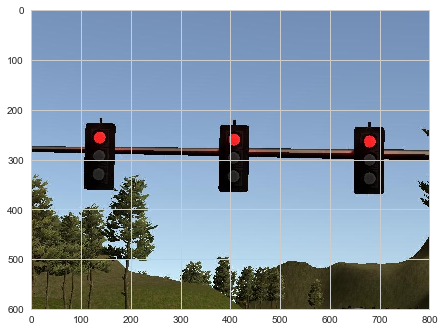

In [10]:
row = df_valid.iloc[0]
im_test = cv2.imread(os.path.join(VALID_DATA_PATH, row.light_state_name, row.file))
im_test = cv2.cvtColor(im_test, cv2.COLOR_BGR2RGB)
plt.imshow(im_test);

For Keras dataflows to work without trouble, we need to push the images to subdirectories first.

In [11]:
def fix_subdirs(df, base_dir):
    categories = df['light_state'].cat.categories.values
    for c in categories:
        class_name = class_map[c]
        path = os.path.join(base_dir, class_name)
        if not os.path.exists(path):
            os.mkdir(path)
    for i, row in df.iterrows():
        class_name = class_map[row.light_state]
        source_path = os.path.join(base_dir, row.file)
        target_path = os.path.join(base_dir, class_name, row.file)
        if os.path.exists(source_path):
            print('move ' + source_path + ' to ' + target_path)
            shutil.move(source_path, target_path)

fix_subdirs(df_train, TRAIN_DATA_PATH)
fix_subdirs(df_valid, VALID_DATA_PATH)

Next, we obtain the base model to use.

In [12]:
from keras.applications.mobilenet import MobileNet, preprocess_input
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense, Input, Activation
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import model_from_json

In [13]:
#graph = tf.Graph().as_default()

In [14]:
input_tensor = Input(shape=(128, 128, 3))
base_model = MobileNet(input_shape=(128, 128, 3), alpha=1.0,
                       include_top=False, weights='imagenet', 
                       input_tensor=input_tensor)

From here, we can define a custom classifier to build on top of the base model.

In [15]:
# https://gist.github.com/fchollet/7eb39b44eb9e16e59632d25fb3119975

for layer in base_model.layers:
    layer.trainable = True

op = Flatten(input_shape=base_model.output_shape[1:])(base_model.output)
op = Dense(256, activation='relu')(op)
op = Dropout(0.5)(op)
op = Dense(4)(op)
op = Activation(tf.nn.softmax)(op)

model = Model(inputs=input_tensor, outputs=op)

Export the model structure:

In [16]:
with open('model.json', 'w') as json_file:
    json_file.write(model.to_json())

Try to load the model:

In [17]:
# https://github.com/keras-team/keras/issues/7431#issuecomment-334959500
from keras.utils.generic_utils import CustomObjectScope

with open('model.json', 'r') as json_file:
    loaded_model_json = json_file.read()
    with CustomObjectScope({'relu6': keras.applications.mobilenet.relu6,'DepthwiseConv2D': keras.applications.mobilenet.DepthwiseConv2D}):
        loaded_model = model_from_json(loaded_model_json)

Train the model:

In [18]:
epochs = 10
batch_size = 16
steps_per_epoch_train_samples = len(df_train) / batch_size
steps_per_epoch_valid_samples = len(df_valid) / batch_size

model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(),
              metrics=['categorical_accuracy'])

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    #height_shift_range=[-32, 32],
    rotation_range=20)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator=train_datagen.flow_from_directory(
    directory=TRAIN_DATA_PATH, 
    #dataframe=df_train, 
    #x_col='file', y_col='light_state_name',
    #class_mode='categorical', 
    classes=class_map,
    target_size=(128, 128), batch_size=32)

valid_generator=test_datagen.flow_from_directory(
    directory=VALID_DATA_PATH,
    #dataframe=df_valid, 
    #x_col='file', y_col='light_state_name', 
    #class_mode='categorical',
    classes=class_map,
    target_size=(128, 128), batch_size=32)

checkpoint = ModelCheckpoint('model-{epoch:03d}.h5', verbose=1, 
                             monitor='val_loss', save_best_only=True, mode='auto')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5,
                           verbose=1, mode='auto')

# fine-tune the model
model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch_train_samples,
    epochs=epochs,
    validation_data=valid_generator,
    validation_steps=steps_per_epoch_valid_samples, 
    callbacks=[checkpoint, early_stop], 
    verbose=True)

Found 7152 images belonging to 4 classes.
Found 784 images belonging to 4 classes.
Epoch 1/10
447/447 [==============================] - 75s - loss: 0.6248 - categorical_accuracy: 0.9079 - val_loss: 0.1278 - val_categorical_accuracy: 0.9510
Epoch 2/10
447/447 [==============================] - 68s - loss: 0.1253 - categorical_accuracy: 0.9653 - val_loss: 0.1432 - val_categorical_accuracy: 0.9588
Epoch 3/10
447/447 [==============================] - 68s - loss: 0.1256 - categorical_accuracy: 0.9643 - val_loss: 0.1345 - val_categorical_accuracy: 0.9594
Epoch 4/10
447/447 [==============================] - 68s - loss: 0.0751 - categorical_accuracy: 0.9767 - val_loss: 0.2166 - val_categorical_accuracy: 0.9562
Epoch 5/10
447/447 [==============================] - 67s - loss: 0.0755 - categorical_accuracy: 0.9766 - val_loss: 0.3129 - val_categorical_accuracy: 0.9117
Epoch 6/10
447/447 [==============================] - 67s - loss: 0.0610 - categorical_accuracy: 0.9813 - val_loss: 0.1769 - va

Save the final weights:

In [19]:
model.save('final.h5')

Re-load the model weights:

In [42]:
loaded_model.load_weights('model-000.h5')

Run a prediction:

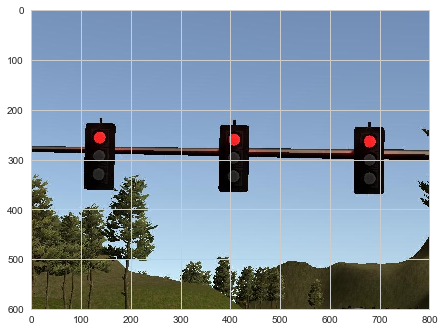

In [51]:
row = df_valid.iloc[0]
im_test = cv2.imread(os.path.join(VALID_DATA_PATH, row.light_state_name, row.file))
im_test = cv2.cvtColor(im_test, cv2.COLOR_BGR2RGB)
plt.imshow(im_test);

In [52]:
image_in = cv2.resize(im_test, (128, 128)) / 255.
model.predict(np.expand_dims(image_in, axis=0))

array([[0., 1., 0., 0.]], dtype=float32)

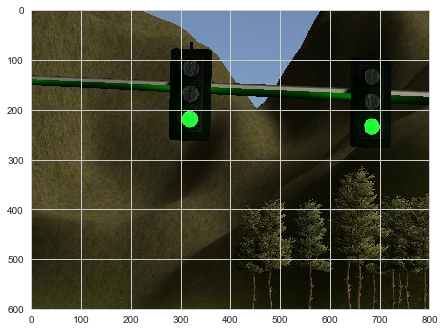

In [53]:
row = df_valid.iloc[300]
im_test = cv2.imread(os.path.join(VALID_DATA_PATH, row.light_state_name, row.file))
im_test = cv2.cvtColor(im_test, cv2.COLOR_BGR2RGB)
plt.imshow(im_test);

In [54]:
image_in = cv2.resize(im_test, (128, 128)) / 255.
model.predict(np.expand_dims(image_in, axis=0))

array([[8.680211e-36, 0.000000e+00, 0.000000e+00, 1.000000e+00]],
      dtype=float32)

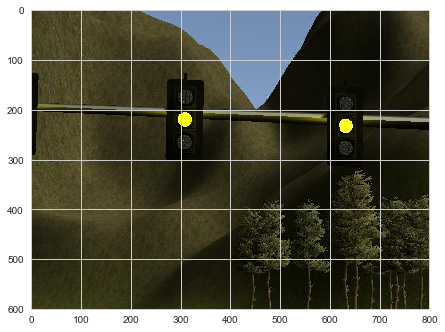

In [55]:
row = df_valid.iloc[320]
im_test = cv2.imread(os.path.join(VALID_DATA_PATH, row.light_state_name, row.file))
im_test = cv2.cvtColor(im_test, cv2.COLOR_BGR2RGB)
plt.imshow(im_test);

In [56]:
image_in = cv2.resize(im_test, (128, 128)) / 255.
model.predict(np.expand_dims(image_in, axis=0))

array([[5.2964526e-07, 3.1848302e-07, 9.9999917e-01, 5.6556164e-09]],
      dtype=float32)

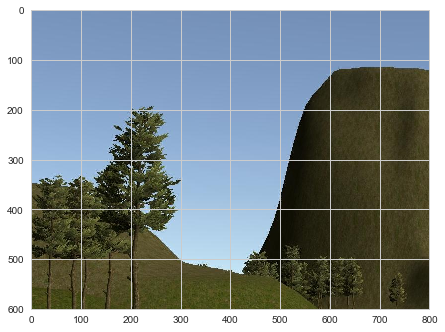

In [59]:
row = df_valid.iloc[100]
im_test = cv2.imread(os.path.join(VALID_DATA_PATH, row.light_state_name, row.file))
im_test = cv2.cvtColor(im_test, cv2.COLOR_BGR2RGB)
plt.imshow(im_test);

In [60]:
image_in = cv2.resize(im_test, (128, 128)) / 255.
model.predict(np.expand_dims(image_in, axis=0))

array([[9.98899221e-01, 1.06616784e-03, 1.34851125e-05, 2.10221369e-05]],
      dtype=float32)